<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA22/blob/main/python/C5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Element Method in 1D - any order

Finite Element Method solver of any order $k$ for the 1D Poisson problem:

$-\Delta u=f \quad \text{in } \Omega=(a,b)$

$u|_{\partial\Omega}=0$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import sympy as sym

In [8]:
# Gauss quadrature formula on [0,1]
def quadrature(n_quadrature_points):

  # use numpy Gauss quadrature. This is defined in [-1,1]
  q, w = np.polynomial.legendre.leggauss(n_quadrature_points)

  return (q+1)/2, w/2

In [2]:
def mesh(omega,N):
  
  return np.linspace(omega[0],omega[1],N+1)

In [3]:
# The reference element is [0,1]. We construct the mappings, the determinant of their Jacobians, and the 
# reference Basis functions
# by L. Heltai

def mapping(q, i):
    """
    Returns the mapping from [0,1] to T_k := [q[k], q[k+1]]
    """
    assert i < len(q)-1
    assert i >= 0
    return lambda x: q[i]+x*(q[i+1]-q[i])

def mapping_J(q,i):
    assert i < len(q)-1
    assert i >= 0
    return (q[i+1]-q[i])

def lagrange_basis(q, i):
    assert i < len(q)
    assert i >= 0
    return lambda x: np.prod([(x-q[j])/(q[i]-q[j]) for j in range(len(q)) if i!=j], axis=0)

# Workaround, to allow lambdify to work also on constant expressions
def np_lambdify(varname, func):
    lamb = sym.lambdify(varname, func, modules=['numpy'])
    if func.is_constant():
        return lambda t: np.full_like(t, lamb(t))
    else:
        return lambda t: lamb(np.array(t))

def lagrange_basis_derivative(q,i,order=1):
    t = sym.var('t')
    return np_lambdify(t, lagrange_basis(q,i)(t).diff(t,order))

In [4]:
def mesh(omega,N):
  
  return np.linspace(omega[0],omega[1],N+1)

FEM code any order

In [5]:
def FEM(omega,M,degree,n_qpoints,rhs):
  # 1D FEM with k=degree system matrix and rhs for
  # diffusion problem

  # Dimension of the problem
  N = M*degree+1

  # grid
  vertices = mesh(omega,M)

  # reference element
  q,w=quadrature(n_qpoints)
  ref_nodes=np.linspace(0,1,degree+1)

  # Evaluation of Lagrange basis
  phi = np.array([lagrange_basis(ref_nodes,i)(q) for i in range(degree+1)]).T
  dphi = np.array([lagrange_basis_derivative(ref_nodes,i)(q) for i in range(degree+1)]).T

  # initialise system
  A = sp.lil_matrix((N, N))
  F = np.zeros(N)

  for i in range(M):
    JxW = mapping_J(vertices,i) * w
    ele_A = np.einsum('qi,qj,q',dphi,dphi,JxW) / mapping_J(vertices,i)**2
    ele_F = np.einsum('qi,q,q',phi,rhs(mapping(vertices, i)(q)),JxW)

    # Assembly local-to-global
    j=i*degree
    m=j+degree+1
    A[j:m,j:m] += ele_A
    F[j:m] += ele_F
    # Assembly local-to-global


  return A, F

Apply boundary conditions

In [6]:
def apply_boundary_conditions(omega,A, F, g):
  # Ideally should scale entries as those of A
  N = A.shape[0] - 1
  A[0,A[0].nonzero()] = 0; A[0,0] = 1;  F[0]=g(omega[0])
  A[N,A[N].nonzero()] = 0; A[N,N] = 1; F[N]=g(omega[1])

and solve

In [9]:
# Problem
omega = [0,np.pi]
rhs = lambda x: np.sin(x)
sol = lambda x: np.sin(x)

# degree of FEM basis
degree = 2

# Number of quadrature points
n_qpoints = 2*degree+1  #(theoretical)

# Number of experiments
no_experiments = 7

# Initialize 
MM = np.zeros(no_experiments)
discrete_max_err = np.zeros(no_experiments)
interpola_H1_err = np.zeros(no_experiments)
conditioning = np.zeros(no_experiments)

# Solution loop
for i in range(no_experiments):
  M = 2**(i+4)
  MM[i] = M
  N = M*degree+1

  # call function computing FEM system
  A, F = FEM(omega,M,degree,n_qpoints,rhs)

  S=A
  # and apply boundary conditions
  apply_boundary_conditions(omega,A, F, sol)

  # Solve the system
  A = A.tocsr()
  Uh = sp.linalg.spsolve(A,F)

  # Compute exact solution
  x = np.linspace(omega[0],omega[1],N)
  U = sol(x)

  # Compute discrete max norm error
  discrete_max_err[i] = max(abs(U-Uh))
  # Compute H1 norm of I_h u - u_h
  interpola_H1_err[i] = (U-Uh).dot(S.dot(U-Uh))

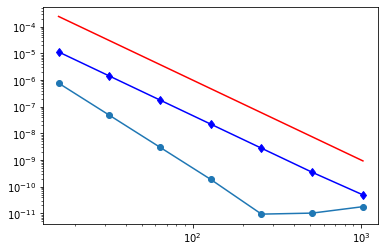

In [10]:
# Error loglog plots
plt.loglog(MM,discrete_max_err,'o-')
plt.loglog(MM,interpola_H1_err**(1/2),'bd-')
plt.loglog(MM,MM**(-(degree+1)),'r')

**Exercise 1**: Write function computing $H^1$-norm error and test convergence for $k>1$.

In [11]:
def FEMk_H1(omega,M,n_qpoints,Uh,dsol,degree):
  # H1 error 
  
  # grid
  vertices = mesh(omega,M)

  # reference element
  q,w=quadrature(n_qpoints)
  ref_nodes=np.linspace(0,1,degree+1)

  # Evaluation of Lagrange basis
  dphi = np.array([lagrange_basis_derivative(ref_nodes,i)(q) for i in range(degree+1)]).T
  # initialise value of norm of error
  error = 0

  # Assembly error
  for i in range(M):
    JxW = mapping_J(vertices,i) * w
    DUUh2 = ( dsol(mapping(vertices,i)(q)) - np.einsum('i,qi',Uh[degree*i:degree*i+degree+1],dphi/mapping_J(vertices,i)))**2 
    error += DUUh2.dot(JxW)

  # Return error
  return error

Test

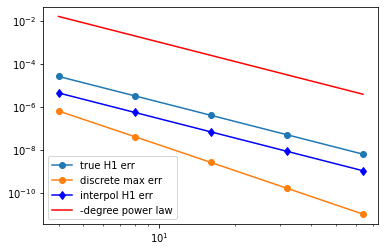

In [13]:
#Problem
omega = [0,1]
rhs = lambda x: np.sin(x)

t = sym.var('t')
my_sol = sym.sin(t)
sol = sym.lambdify(t, my_sol )
d_sol = sym.lambdify(t, my_sol.diff(t, 1) )

#degreee of FEM basis
degree=3
# Number of quadrature points
n_qpoints = 2*degree+1  #(theoretical)
# Number of experiments
no_experiments = 5

# Initialize 
MM = np.zeros(no_experiments)
true_H1_err = np.zeros(no_experiments)
discrete_max_err=np.zeros(no_experiments)
interpola_H1_err=np.zeros(no_experiments)

for i in range(no_experiments):
  M = 2**(i+2)
  MM[i] = M
  N=M*degree+1
  # call function computing FEM system
  A, F = FEM(omega,M,degree,n_qpoints,rhs)


  # and apply boundary conditions
  apply_boundary_conditions(omega, A, F, sol)


  # Solve the system
  A = A.tocsr()
  Uh = sp.linalg.spsolve(A,F)

  # Evaluate derivative of exact solution 
  true_H1_err[i] = FEMk_H1(omega,M,7,Uh,d_sol,degree)

  # Compute exact solution
  x = np.linspace(omega[0],omega[1],N)
  U = sol(x)

  # Compute discrete max norm error
  discrete_max_err[i] = max(abs(U-Uh))
  # Compute H1 norm of I_h u - u_h
  interpola_H1_err[i] = (U-Uh).dot(A.dot(U-Uh))


# Error loglog plots
fig,ax=plt.subplots()
ax.loglog(MM,true_H1_err**(1/2),'o-',label="true H1 err")
ax.loglog(MM,discrete_max_err,'o-',label="discrete max err")
ax.loglog(MM,interpola_H1_err**(1/2),'bd-',label="interpol H1 err")
ax.loglog(MM,MM**(-(degree)),'r',label="-degree power law")
ax.legend()

# Linear FEM code with mesh class

Proper 1D mesh class

In [14]:
class IntervalMesh(object):
    """
    This class contains the implementation of 1D mesh.

    Parameters
    ----------
    vertices : 1D numpy array
        numpy array containing the coordinates of the vertices of the mesh
    cells : 2D numpy array
        numpy array containing the connectivity from topological dimension 1 to topological dimension 0,
        given a row index c (which corresponds to the c-th cell) what are the two IDs of the two vertices
        of the cell c

    Attributes
    ----------
    topology : dict
        dictionary mapping the pair (topological dimension i, topological dimension j)
        to the connectivity i to j.
        Notable cases:
            * (i, j) = (0, 0): this case is not stored, because it would be the identity
            * (i, j) = (0, 1): the connectivity 0 to 1 is a dictionary mapping the
                               ID of the vertex to the IDs of all cells incident on that vertex.
                               This is obtained reversing the "cells" input argument.
            * (i, j) = (1, 0): the connectivity 1 to 0 is a dictionary mapping the
                               ID of the cell to the IDs of all vertices of that cell.
                               Note that this is simply the "cells" input argument!
            * (i, j) = (1, 1): this case is not stored, because it would be the identity
    num_entities : dict
        dictionary mapping the topological dimension i to the number of entities of that dimension
        Notable cases:
            * i = 0: number of vertices in the mesh
            * i = 1: number of cells in the mesh
    geometry : dict
        dictionary mapping the topological dimension i to the coordinates for all entities of
        that dimension.
        Notable cases:
            * i = 0: the geometry 0 is a dictionary mapping the ID of the vertex to its coordinate.
                     Note that this is simply the "vertices" input argument!
            * i = 1: this case is not stored, because it suffices to use the topological information
                     to recover geometrical locations of cells once vertices coordinates are known
    by F. Ballarin
    """

    def __init__(self, vertices, cells):
        num_vertices = vertices.shape[0]
        num_cells = cells.shape[0]

        # --- Topological definition --- #
        # (i, j) = (1, 0)
        cells_to_vertices_connectivity = {
            # ID of the cell: IDs of all vertices of that cell
            c: cells[c, :] for c in range(num_cells)
        }
        # (i, j) = (0, 1)
        vertices_to_cells_connectivity = {
            # ID of the vertex: IDs of all cells incident on that vertex
            v: list() for v in range(num_vertices)
        }
        for c in range(num_cells):
            for v in cells[c, :]:
                vertices_to_cells_connectivity[v].append(c)
        # Store the connectivities
        self.topology = {
            # (topological dimension i, topological dimension j): connectivity i to j
            (1, 0): cells_to_vertices_connectivity,
            (0, 1): vertices_to_cells_connectivity
            # note that there are no "(0, 0)" and "(1, 1)" cases, because they are not needed
            # (as they would be the identity).
        }
        # Store the number of entities
        self.num_entities = {
            # dimension: number of entities of that dimension
            0: num_vertices,
            1: num_cells
        }

        # --- Geometrical definition --- #
        # i = 0
        vertices_coordinates = {
            # vertex id: vertex coordinate
            v: vertices[v] for v in range(num_vertices)
        }
        # Store the geometry
        self.geometry = {
            # dimension: coordinates for all entities of that dimension
            0: vertices_coordinates
            # note that there is no case "1: ", because it is not needed (as it suffices to use
            # topological information to recover geometrical locations of edges once vertex
            # coordinates are known).
        }

Implementation of uniform mesh

In [15]:
def equispaced_interval_mesh(interval, n):
    """
    Generate a 1D mesh of the interval provided as the first argument composed of n cells of equal length,
    by initializing an IntervalMesh object.

    Parameters
    ----------
    interval : list
        list of two numbers, representing the two endpoints on the domain.
    n : int
        number of cells.

    Returns
    -------
    IntervalMesh
        object representing the mesh of the interval.
    """

    vertices = np.linspace(interval[0], interval[1], n + 1)
    cells = np.array([[i, i + 1] for i in range(n)])

    #print("Generating 1D mesh on the interval", interval, "with", n, "cells")
    #print("Vertices:\n", vertices)
    #print("Cells:\n", cells)
    return IntervalMesh(vertices, cells)

Test unifrom mesh

Implementation of nonuniform mesh obtained by perturbation of uniform mesh

In [16]:
def random_interval_mesh(interval, n):
    """
    Generate a 1D mesh of the interval provided as the first argument composed of n cells of equal length,
    by initializing an IntervalMesh object.

    Parameters
    ----------
    interval : list
        list of two numbers, representing the two endpoints on the domain.
    n : int
        number of cells.

    Returns
    -------
    IntervalMesh
        object representing the mesh of the interval.
    """

    # Uniform mesh
    vertices = np.linspace(interval[0], interval[1], n + 1)
    # Random perturbation
    h=(interval[1]-interval[0])/n
    for i in range(1,n):
        vertices[i]+= (h/3)*(2*np.random.rand(1)-1)


    cells = np.array([[i, i + 1] for i in range(n)])

    return IntervalMesh(vertices, cells)

In [17]:
mesh=random_interval_mesh([0,1],7)
print(np.size(mesh.topology[(0,1)][1]))


2


Our old Transformation of coordinates functions

In [18]:
# Transformation of coordinates:
# reference element -> current element
# [0,1] -> [q[i], q[i+1]]

def mapping(q, i):
    
    # check index is within range
    assert i < len(q)-1
    assert i >= 0

    return lambda x: q[i]+x*(q[i+1]-q[i])

def mapping_J(q,i):
    assert i < len(q)-1
    assert i >= 0
    return (q[i+1]-q[i])

# Linear lagrange basis on reference element
def basis1(i):
    assert i < 2
    assert i >= 0
    if i == 0:
      phi = lambda x: 1-x
    else:
      phi = lambda x: x
    return phi

# Linear lagrange basis derivatives on reference element
def basis1_derivative(i):
    assert i < 2
    assert i >= 0
    if i == 0:
      dphi = lambda x: -np.ones(len(x))
    else:
      dphi = lambda x: np.ones(len(x))
    return dphi

New function implementing linear FEM system

In [19]:
def FEM1_1D_GAUSS(omega,mesh,n_qpoints,rhs):
  # 1D FEM with k=1 system matrix and rhs for
  # diffusion problem with
  # homogeneous Dirichlet bc
  # uniform grid

  # grid
  vertices=np.array(list(mesh.geometry[0].values()))
  cells=mesh.topology[(1,0)]
  N=vertices.size
  # quadrature formula on reference element
  q, w = quadrature(n_qpoints)

  # Evaluation of linear Lagrange basis 
  phi = np.array([basis1(i)(q) for i in range(2)]).T
  dphi = np.array([basis1_derivative(i)(q) for i in range(2)]).T

  # initialise system
  A = sp.lil_matrix((N, N))
  F = np.zeros(N)

  for i in cells:
    JxW = mapping_J(vertices,i) * w
    ele_A = np.einsum('qi,qj,q',dphi,dphi,JxW) / mapping_J(vertices,i)**2#h**2
    ele_F = np.einsum('qi,q,q',phi,rhs(mapping(vertices, i)(q)),JxW)

    # Assembly local-to-global
    A[np.ix_(cells[i],cells[i])]+= ele_A
    F[cells[i]] += ele_F


  return A, F

Apply boundary conditions

In [20]:
def apply_boundary_conditions(omega,mesh, A, F, g):
  # Ideally should scale entries as those of A
  vertices=np.array(list(mesh.geometry[0].values()))
  cells=mesh.topology[(1,0)]
  N=vertices.size
  for i in range(N):
      if np.size(mesh.topology[(0,1)][i])==1:
        A[i,A[i].nonzero()]=0;A[i,i]=1;F[i]=g(vertices[i])


Solve problem

In [21]:
omega = [0,np.pi]
rhs = lambda x: np.sin(x)#np.ones(len(x))
exact = lambda x: np.sin(x)

# Number of Gauss quadrature points
n_qpoints = 3

# Number of intervals
N=10; 
mesh = equispaced_interval_mesh(omega, N)
#mesh = random_interval_mesh(omega, N)
#print(np.array(list(mesh.geometry[0].values())))

A, F = FEM1_1D_GAUSS(omega,mesh,n_qpoints,rhs)
apply_boundary_conditions(omega,mesh, A, F, exact)

#print(A.todense())

A = A.tocsr()
Uh = sp.linalg.spsolve(A,F)

x = np.linspace(omega[0],omega[1],N+1)

U = exact(x)

print("discrete max norm error = ", max(abs(U-Uh)))

discrete max norm error =  2.3956477912534524e-09


**Exercise**: Implement FEM of any order using the mesh class approach 

In [22]:
def FEM_kdegree_meshapproach(mesh,degree,n_qpoints,rhs):
  # 1D FEM with k=degree system matrix and rhs for
  # diffusion problem

  # grid
  vertices = np.array(list(mesh.geometry[0].values()))
  cells=mesh.topology[(1,0)]
  # Dimension of the problem
  N = M*degree+1

  # reference element
  q,w=quadrature(n_qpoints)
  ref_nodes=np.linspace(0,1,degree+1)

  # Evaluation of Lagrange basis
  phi = np.array([lagrange_basis(ref_nodes,i)(q) for i in range(degree+1)]).T
  dphi = np.array([lagrange_basis_derivative(ref_nodes,i)(q) for i in range(degree+1)]).T

  # initialise system
  A = sp.lil_matrix((N, N))
  F = np.zeros(N)

  for i in cells:
    JxW = mapping_J(vertices,i) * w
    ele_A = np.einsum('qi,qj,q',dphi,dphi,JxW) / mapping_J(vertices,i)**2
    ele_F = np.einsum('qi,q,q',phi,rhs(mapping(vertices, i)(q)),JxW)
    #print ("shape ele_A=", ele_A.shape)
    # Assembly local-to-global
    j=cells[i][0]*degree
    print("j=",j)
    m=j+degree+1
    A[j:m,j:m] += ele_A
    F[j:m] += ele_F
    print(A.todense())

    # Assembly local-to-global


  return A, F

ESPERIMENTO  0
ESPERIMENTO  1
j= 0
[[ 2.33333333 -2.66666667  0.33333333]
 [-2.66666667  5.33333333 -2.66666667]
 [ 0.33333333 -2.66666667  2.33333333]]
ESPERIMENTO  2
j=

C:\Users\lollopc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


 0
[[ 4.66666667 -5.33333333  0.66666667  0.          0.        ]
 [-5.33333333 10.66666667 -5.33333333  0.          0.        ]
 [ 0.66666667 -5.33333333  4.66666667  0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
j= 2
[[ 4.66666667 -5.33333333  0.66666667  0.          0.        ]
 [-5.33333333 10.66666667 -5.33333333  0.          0.        ]
 [ 0.66666667 -5.33333333  9.33333333 -5.33333333  0.66666667]
 [ 0.          0.         -5.33333333 10.66666667 -5.33333333]
 [ 0.          0.          0.66666667 -5.33333333  4.66666667]]
ESPERIMENTO  3
j= 0
[[ 7. -8.  1.  0.  0.  0.  0.]
 [-8. 16. -8.  0.  0.  0.  0.]
 [ 1. -8.  7.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
j= 2
[[ 7. -8.  1.  0.  0.  0.  0.]
 [-8. 16. -8.  0.  0.  0.  0.]
 [ 1. -8. 14. -8.  1.  0.  0.]
 [ 0.  0. -8. 16. -8.  0

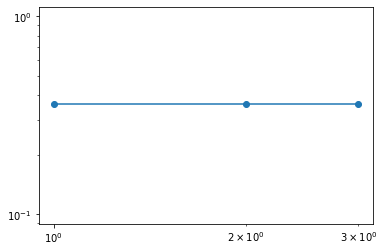

In [93]:
#Problem
omega = [0,1]
rhs = lambda x: np.sin(x)

t = sym.var('t')
my_sol = sym.sin(t)
sol = sym.lambdify(t, my_sol )
d_sol = sym.lambdify(t, my_sol.diff(t, 1) )

#degreee of FEM basis
degree=2
# Number of quadrature points
n_qpoints = 2*degree+1  #(theoretical)
# Number of experiments
no_experiments = 4

# Initialize 
MM = np.zeros(no_experiments)
discrete_max_err=np.zeros(no_experiments)
true_H1_err = np.zeros(no_experiments)

for i in range(no_experiments):
  print("ESPERIMENTO ",i)
  M = i
  MM[i] = M
  mesh = equispaced_interval_mesh(omega, M)
  N=M*degree+1
  # call function computing FEM system
  A, F = FEM_kdegree_meshapproach(mesh,degree,n_qpoints,rhs)


  # and apply boundary conditions
  apply_boundary_conditions(omega,mesh, A, F, sol)


  # Solve the system
  A = A.tocsr()
  Uh = sp.linalg.spsolve(A,F)

  # Evaluate derivative of exact solution 
 # true_H1_err[i] = FEMk_H1(omega,M,7,Uh,d_sol,degree)

  #Compute exact solution
  x = np.linspace(omega[0],omega[1],N)
  U = sol(x)

  # Compute discrete max norm error
  discrete_max_err[i] = max(abs(U-Uh))
  # Compute H1 norm of I_h u - u_h
  #interpola_H1_err[i] = (U-Uh).dot(A.dot(U-Uh))


# Error loglog plots
fig,ax=plt.subplots()
#ax.loglog(MM,true_H1_err**(1/2),'o-',label="true H1 err")
ax.loglog(MM,discrete_max_err,'o-',label="discrete max err")
#ax.loglog(MM,interpola_H1_err**(1/2),'bd-',label="interpol H1 err")
#ax.loglog(MM,MM**(-(degree)),'r',label="-degree power law")
#ax.legend()